In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import libraries

In [2]:
from tensorflow.keras.datasets import mnist
#import Mnist

In [3]:
(X_train,y_train),(X_test, y_test)=mnist.load_data()
#Divide into train and test data

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
y_cat_test=to_categorical(y_test,num_classes=10)
y_cat_train=to_categorical(y_train,num_classes=10)
#One hot encode the labels

In [7]:
X_train=X_train/255
X_test=X_test/255
#scale features

In [8]:
# batch size
X_train=X_train.reshape(60000,28,28,1)
X_test=X_test.reshape(10000,28,28,1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten

In [10]:
#Create CNN based model
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding='valid',
                input_shape=(28,28,1),activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

# Output Layer softmax-->multiclass

model.add(Dense(10,activation='softmax'))

#keras.io/metrics

model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])

In [11]:
#Use early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=1)
model.fit(X_train,y_cat_train,epochs=10,validation_data=(X_test,y_cat_test),
         callbacks=[early_stop])

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1374 - accuracy: 0.9596 - val_loss: 0.0606 - val_accuracy: 0.9794
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.0380 - val_accuracy: 0.9870
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0302 - accuracy: 0.9903 - val_loss: 0.0621 - val_accuracy: 0.9803


In [12]:
metrics=pd.DataFrame(model.history.history)

In [13]:
#evaluate model
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.137397,0.959617,0.060617,0.9794
1,0.047042,0.985150,0.038024,0.9870
2,0.030222,0.990333,0.062139,0.9803


In [14]:
#Print precision and recall
from sklearn.metrics import classification_report,confusion_matrix
predictions=model.predict_classes(X_test)
print(classification_report(y_test,predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       1.00      0.96      0.98      1032
           3       0.94      1.00      0.97      1010
           4       0.99      0.99      0.99       982
           5       0.95      0.99      0.97       892
           6       1.00      0.96      0.98       958
           7       0.96      1.00      0.98      1028
           8       1.00      0.95      0.97       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg    

In [15]:
#Print confusion matrix
confusion_matrix(y_test,predictions)

array([[ 971,    0,    2,    1,    1,    3,    0,    0,    1,    1],
       [   0, 1123,    1,    4,    0,    2,    1,    4,    0,    0],
       [   1,    2,  990,   20,    1,    0,    0,   17,    1,    0],
       [   0,    0,    0, 1005,    0,    4,    0,    0,    1,    0],
       [   0,    0,    0,    0,  975,    0,    0,    1,    0,    6],
       [   0,    0,    0,    9,    0,  882,    1,    0,    0,    0],
       [   8,    1,    0,    3,    7,   16,  923,    0,    0,    0],
       [   0,    0,    0,    3,    0,    1,    0, 1023,    1,    0],
       [   2,    0,    0,   19,    0,   17,    0,    7,  925,    4],
       [   1,    0,    0,    7,    2,    4,    0,    9,    0,  986]],
      dtype=int64)

Now that we have our model, we can use the fast gradient sign method to create adversarial examples

In [16]:
import tensorflow as tf

In [17]:
#Create a loss object for the fast gradient sign method
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [18]:
#Pick an image to use the fast gradient sign method on and convert to a tensorflow tensor
adversarial_test=X_test[26]
adversarial_test=tf.cast(adversarial_test,tf.float32)
adversarial_test=tf.image.resize(adversarial_test,(28,28))
adversarial_test=adversarial_test[None,...]

In [19]:
#Get label of image for creating the adversarial example
adversarial_test_answer=y_cat_test[26]
adversarial_test_answer=tf.reshape(adversarial_test_answer,(1,10))

In [20]:
def create_perturbation(input_image, input_label):
    with tf.GradientTape() as tape:
        #Make independent variable the input image
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
     # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [21]:
#Generate perturbations
perturbations = create_perturbation(adversarial_test, adversarial_test_answer)

In [22]:
perturbations.shape

TensorShape([1, 28, 28, 1])

In [23]:
perturbations

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]],

        [[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [-1.],
         [ 1.]],

        [[ 1.],
         [ 1.],
         [ 1

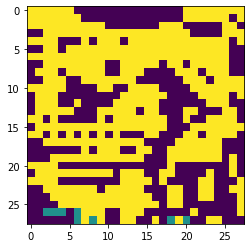

In [24]:
plt.imshow(perturbations[0]*0.5+0.5); # To scale from (-1,1) to (0,1)

In [25]:
#Introduce perturbation to image
adv_x=adversarial_test+0.08*perturbations

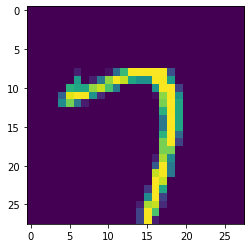

In [26]:
plt.imshow(adversarial_test[0])

In [27]:
model(adversarial_test)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[9.9866611e-07, 9.1984106e-08, 7.9529582e-06, 3.2559488e-05,
        9.3120590e-08, 2.2030828e-07, 2.7885732e-12, 9.9994719e-01,
        2.9226507e-08, 1.0813650e-05]], dtype=float32)>

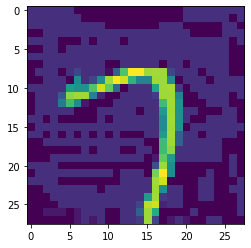

In [28]:
plt.imshow(adv_x[0])

In [29]:
#Show model prediction of perturbation of image
model(adv_x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.7176197e-05, 1.6535258e-05, 1.8394503e-03, 9.2570549e-01,
        6.5586551e-06, 2.9130737e-04, 4.9319338e-10, 6.9887474e-02,
        1.6402168e-05, 2.2196618e-03]], dtype=float32)>

In [30]:
#This predicts a 3